<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/regression_drift_0516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [4]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

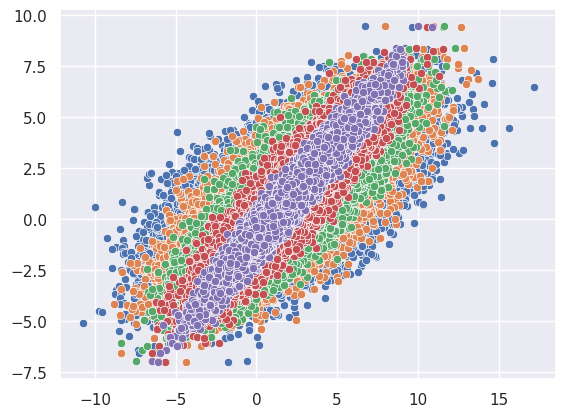

In [5]:
seed_everything()
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

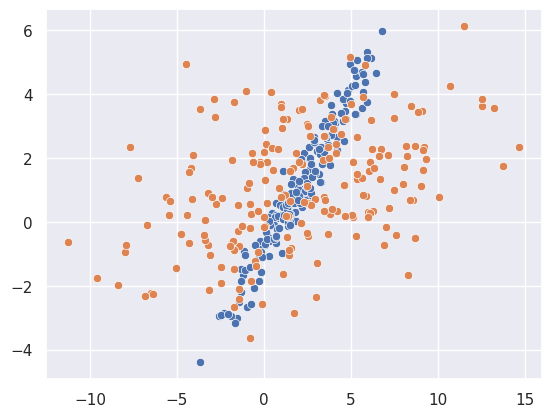

In [6]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.810444
x2    0.512920
x1    0.350373
z0    0.255009
x0    0.238650
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


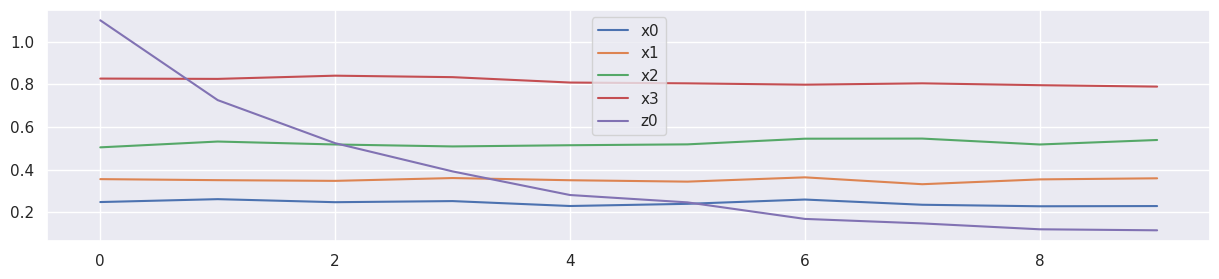

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 39.15it/s]


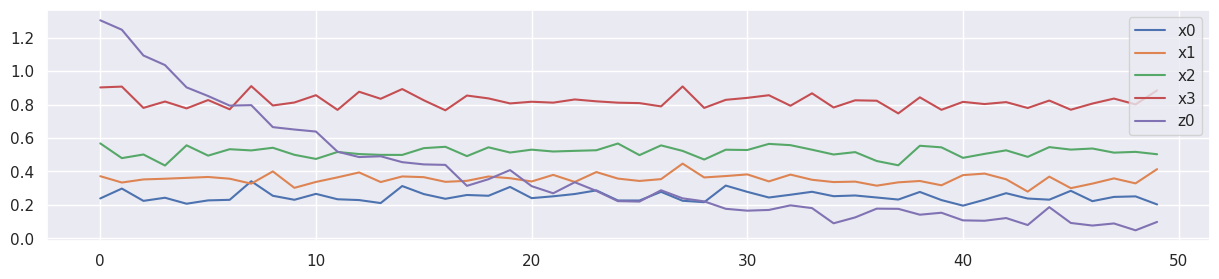

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 52.24it/s]


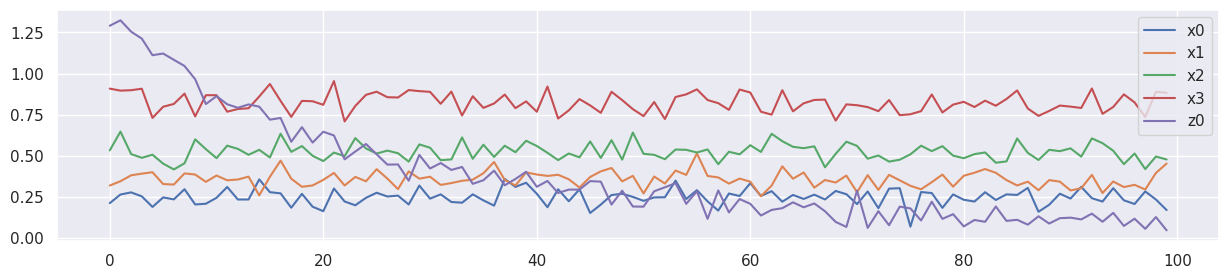

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 66.79it/s]


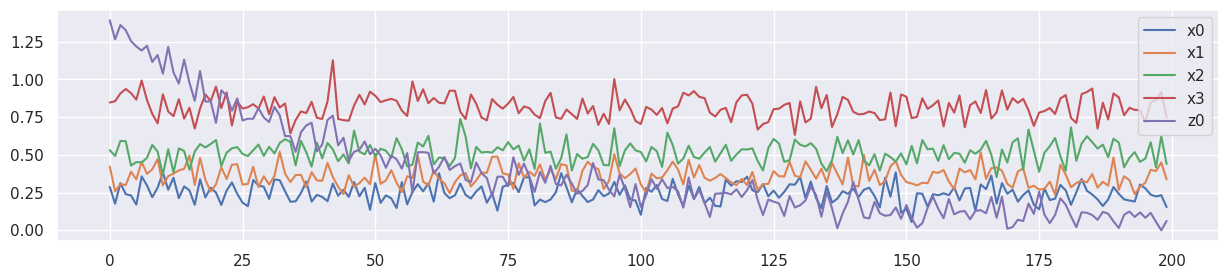

In [9]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

## ks-test 

In [10]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 267.41it/s]


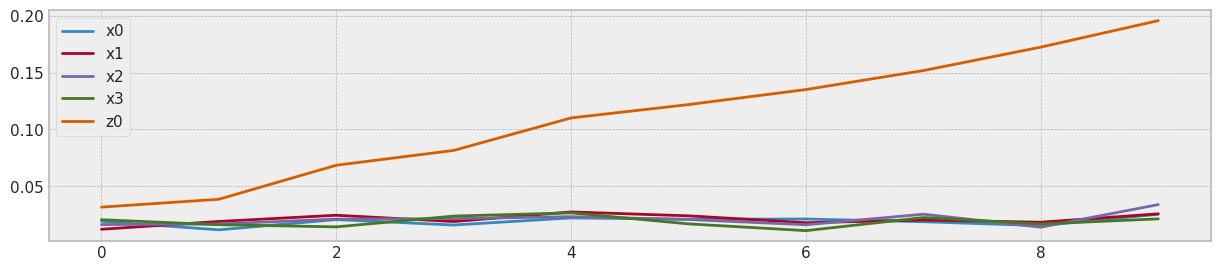

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 631.02it/s]


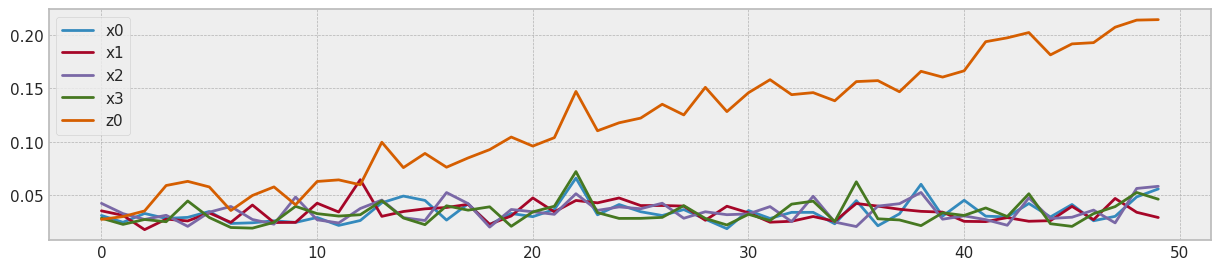

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 697.33it/s]


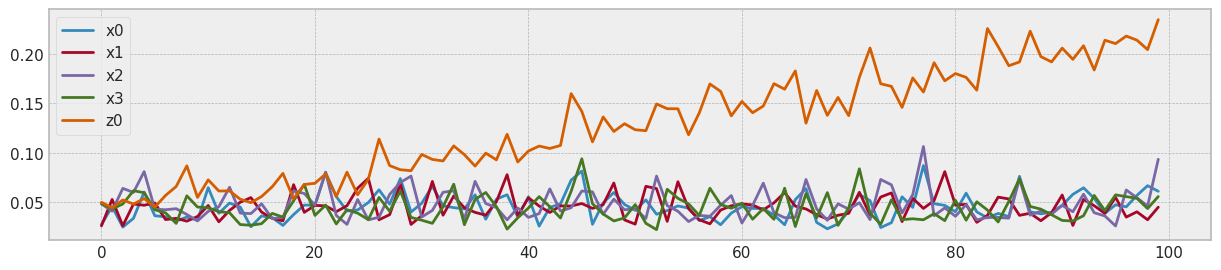

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 566.42it/s]


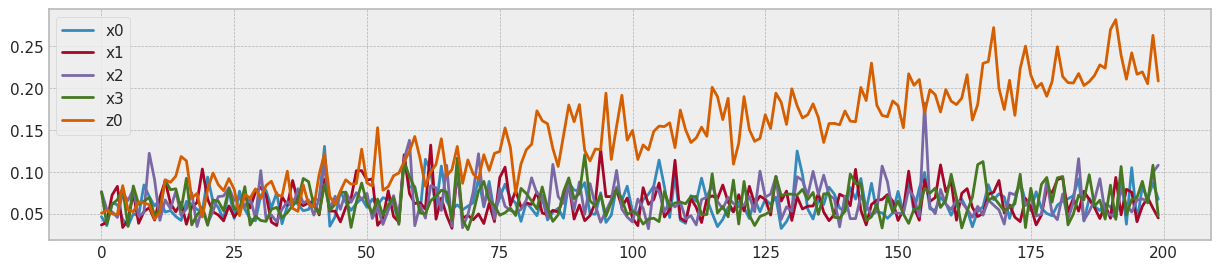

In [11]:

from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 28.57it/s]


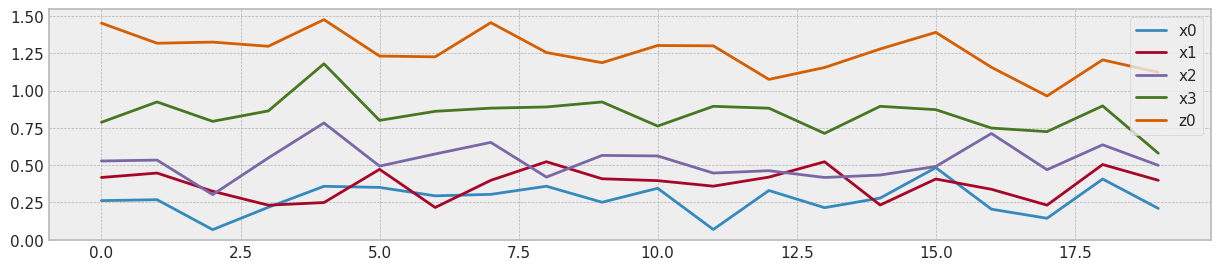

In [12]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


MSE: 0.26
RMSE: 0.51


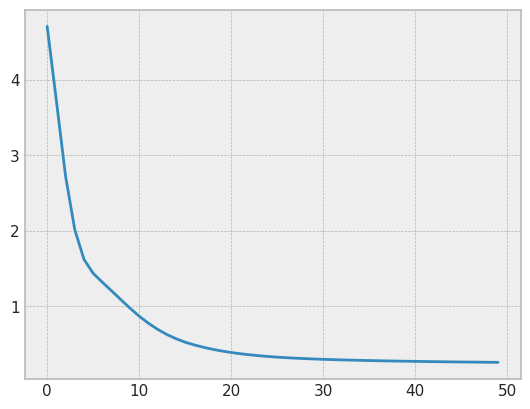

In [13]:
import copy
import torch.optim as optim
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ R2 측정

In [14]:
from sklearn.metrics import r2_score
predicted_y = model(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.9374587357625266


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 1489.71it/s]


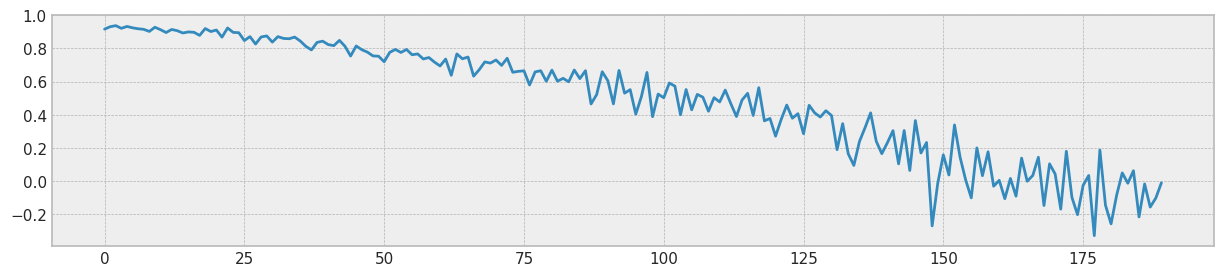

In [15]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    r2s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        r2s.append(r2)
    plt.figure(figsize=(15,3))
    plt.plot(r2s)
    plt.show()


# Generator + Discriminator 구조

+ Generator에 control factor 'z' 를 대입하여, r2가 1~0 까지 전개되도록 학습한다.

$$
L=mse(D(G(x,z=0)),y) + mse(D(G(x,z=1),shuffle(y))) 
$$

In [16]:

# Define the Generator
class Generator(nn.Module):

    def __init__(self, input_dim):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim)
        )

    def forward(self, x,b):
        input_data = torch.cat((x,torch.zeros(x.shape[0],1) + b),1)        
        output = self.model(input_data)
        return output
'''
# Define the Generator
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 30))
            self.fc2.append(nn.Linear(30, 1))

    def forward(self, x, b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),torch.zeros(x.shape[0],1) + b), 1)))
            h1 = self.fc2[i](h0)
            pxy.append(h1)
            
        return torch.cat(pxy, dim=1)      
'''           

'\n# Define the Generator\nclass Generator(nn.Module):\n\n    def __init__(self,input_dim):\n        super(Generator, self).__init__()\n        self.input_dim = input_dim\n        self.fc1 = nn.ModuleList()\n        self.fc2 = nn.ModuleList()\n        \n        for i in range(self.input_dim): \n            self.fc1.append(nn.Linear(2, 30))\n            self.fc2.append(nn.Linear(30, 1))\n\n    def forward(self, x, b):\n        pxy = []\n        for i in range(self.input_dim):\n            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),torch.zeros(x.shape[0],1) + b), 1)))\n            h1 = self.fc2[i](h0)\n            pxy.append(h1)\n            \n        return torch.cat(pxy, dim=1)      \n'

In [19]:

# Define the Generator
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, input_data):
        output = self.model(input_data)
        return output

  2%|▏         | 1/50 [00:00<00:16,  2.96it/s]

[Epoch 0/50] [A loss: 0.517088] [B loss: 0.577224] [G loss: 0.517082]


 22%|██▏       | 11/50 [00:03<00:13,  2.82it/s]

[Epoch 10/50] [A loss: 0.216428] [B loss: 10.394750] [G loss: 0.216324]


 42%|████▏     | 21/50 [00:07<00:10,  2.87it/s]

[Epoch 20/50] [A loss: 0.225806] [B loss: 32.608372] [G loss: 0.225480]


 62%|██████▏   | 31/50 [00:11<00:08,  2.18it/s]

[Epoch 30/50] [A loss: 0.237330] [B loss: 65.106018] [G loss: 0.236679]


 82%|████████▏ | 41/50 [00:15<00:03,  2.92it/s]

[Epoch 40/50] [A loss: 0.234135] [B loss: 108.907150] [G loss: 0.233046]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


MSE: 0.28
RMSE: 0.53


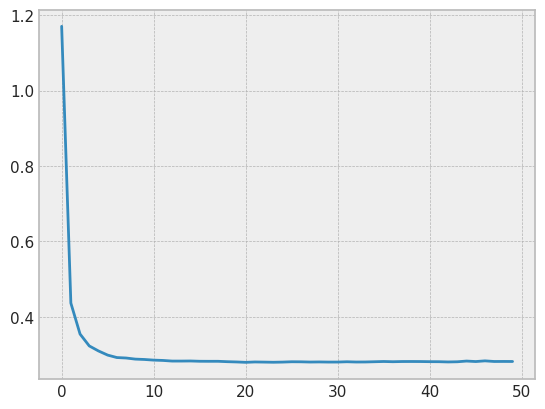

In [31]:
import copy
import torch.optim as optim
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Initializes generator and discriminator
generator = Generator(5)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)

discriminator = Discriminator()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss function and optimizer
mse_loss = nn.MSELoss()  # mean square error
 
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            #  Forword Generator for z=0 
            g0 = generator(X_batch,0)

            #  Forword Generator for z=1 
            g1 = generator(X_batch,1)

            a_loss = mse_loss(discriminator(g0), y_batch.reshape(-1,1))
            #b_loss = mse_loss(discriminator(g1), shuffled_y.reshape(-1,1))
            b_loss = mse_loss(discriminator(g1), y_batch.reshape(-1,1))

            loss = a_loss - b_loss * 0.00001

            # backward pass
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            loss.backward()
            # update weights
            optimizer_G.step()
            optimizer_D.step()    
            # print progress
            bar.set_postfix(mse=float(loss))


    if epoch % 10 == 0:
        print(
                "[Epoch %d/%d] [A loss: %f] [B loss: %f] [G loss: %f]"
                % (epoch, n_epochs, a_loss, b_loss, loss)
            )
            
    # evaluate accuracy at end of each epoch
    generator.eval()
    discriminator.eval()
    
    y_pred = discriminator(generator(X_test,0))
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [43]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,0))
#predicted_y = discriminator(X_test)
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score 0.93179101676754


In [42]:
from sklearn.metrics import r2_score
predicted_y = discriminator(generator(X_test,1))
r2 = r2_score(y_test,predicted_y.detach().numpy())
print('R-squared score',r2)

R-squared score -39.16710966085451


## controllor z에 따른 R2 제어

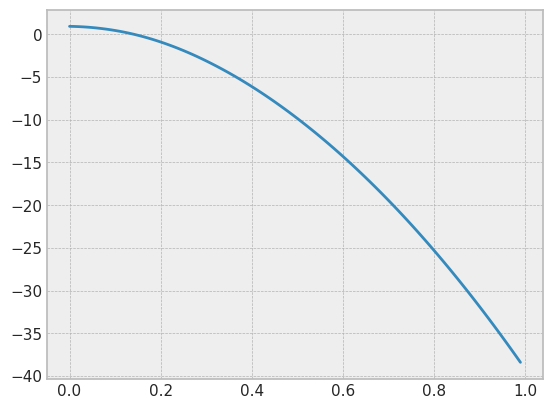

In [51]:
r2s = []
for cb in range(0, 100, 1) :
    predicted_y = discriminator(generator(X_test,cb/100))
    r2 = r2_score(y_test,predicted_y.detach().numpy())
    r2s.append([cb/100,r2])

r2s = np.asarray(r2s)
plt.plot(r2s[:,0],r2s[:,1])

In [52]:
r2s

array([[ 0.00000000e+00,  9.31791017e-01],
       [ 1.00000000e-02,  9.18790951e-01],
       [ 2.00000000e-02,  8.98538888e-01],
       [ 3.00000000e-02,  8.70607662e-01],
       [ 4.00000000e-02,  8.34713601e-01],
       [ 5.00000000e-02,  7.90319400e-01],
       [ 6.00000000e-02,  7.37755590e-01],
       [ 7.00000000e-02,  6.77144594e-01],
       [ 8.00000000e-02,  6.08721193e-01],
       [ 9.00000000e-02,  5.31882410e-01],
       [ 1.00000000e-01,  4.46850216e-01],
       [ 1.10000000e-01,  3.53382307e-01],
       [ 1.20000000e-01,  2.51053670e-01],
       [ 1.30000000e-01,  1.38992552e-01],
       [ 1.40000000e-01,  1.79558297e-02],
       [ 1.50000000e-01, -1.12042062e-01],
       [ 1.60000000e-01, -2.51847855e-01],
       [ 1.70000000e-01, -4.00834353e-01],
       [ 1.80000000e-01, -5.57787323e-01],
       [ 1.90000000e-01, -7.23484579e-01],
       [ 2.00000000e-01, -8.98104726e-01],
       [ 2.10000000e-01, -1.08160621e+00],
       [ 2.20000000e-01, -1.27399805e+00],
       [ 2.

## drift의 측정

+ 일단 생 y의 drift

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 457.82it/s]


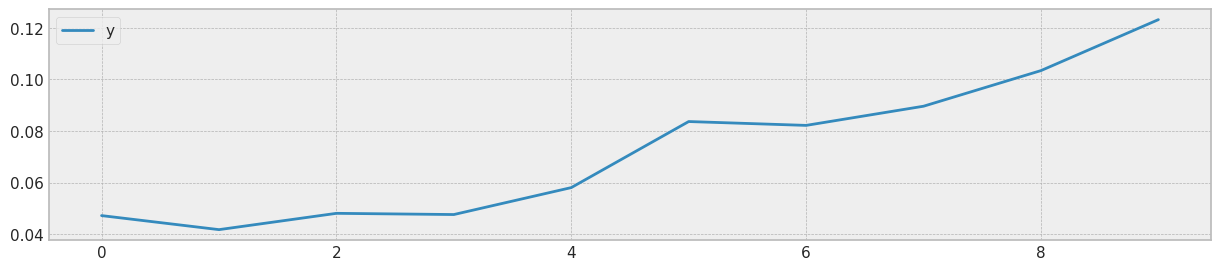

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 1171.29it/s]


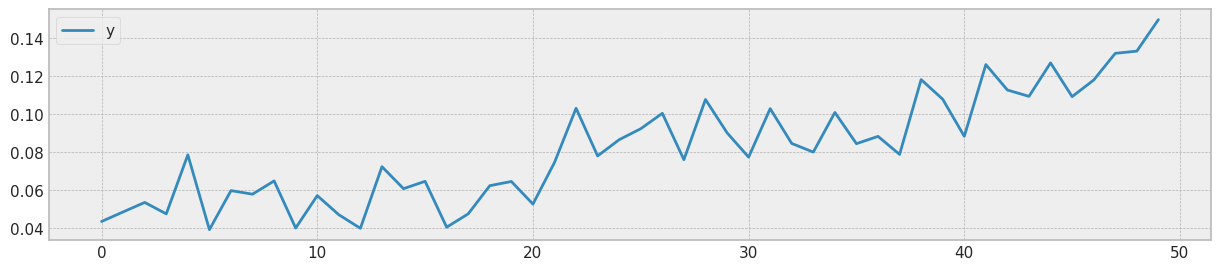

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 1346.93it/s]


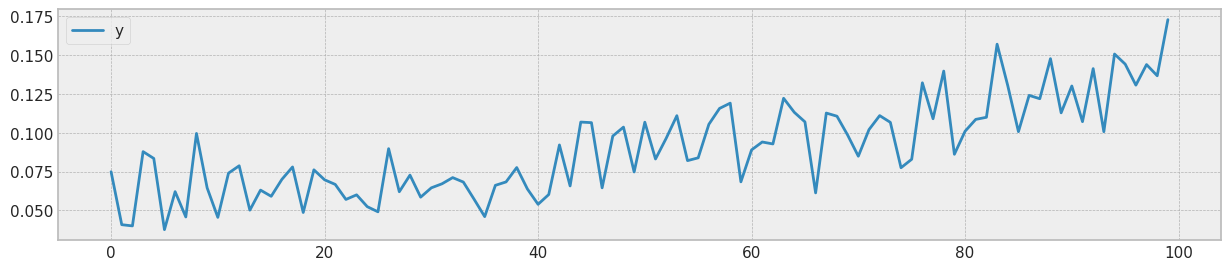

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 890.74it/s]


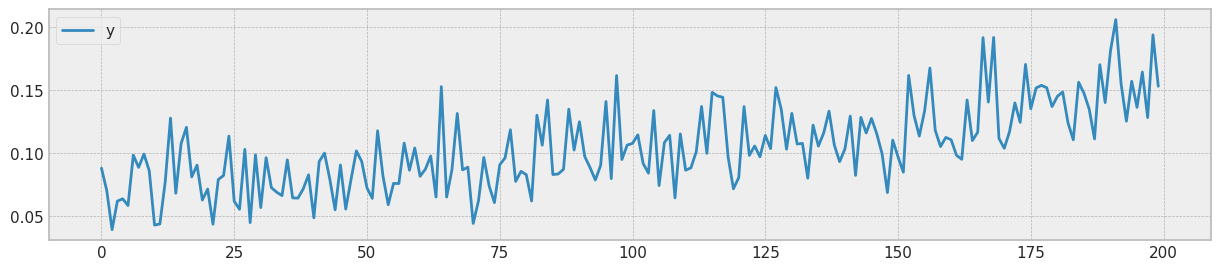

In [62]:

from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*step_size+2000:bk*step_size+step_size+2000].values, dtype=torch.float32)
        predicted_y = discriminator(generator(tx,0))
        ks = __ks_drift(y[0:1800].reshape(-1,1),predicted_y.detach().numpy())
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()


+ z로 controll한 N개의 predicted_y의 drift

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 119.11it/s]


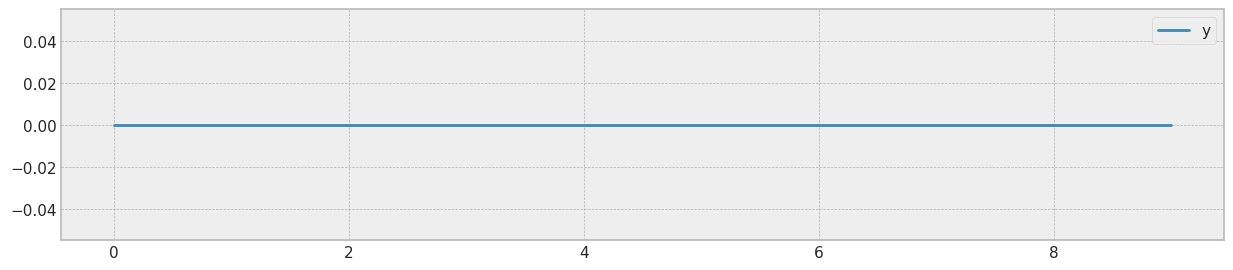

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 883.47it/s]


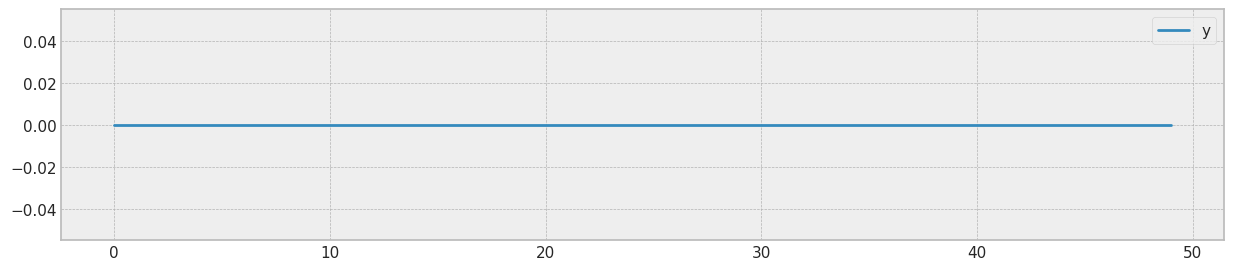

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 999.47it/s]


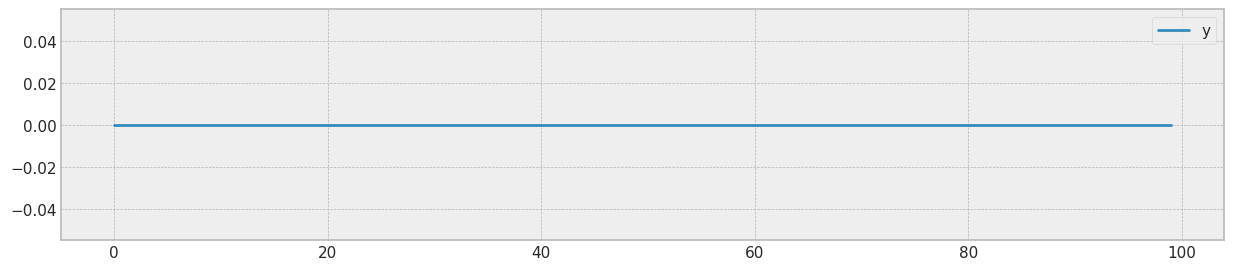

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 1102.43it/s]


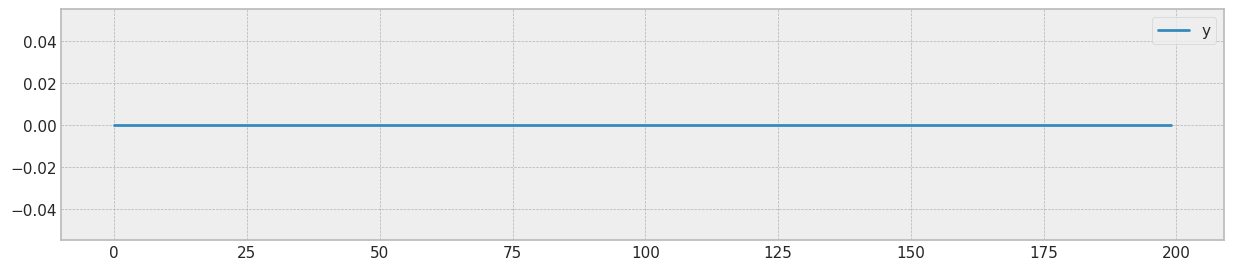

In [64]:
from tqdm import tqdm
from scipy.stats import entropy
bucket_size_array=[10,50,100,200]

tx = torch.tensor(X[0:2000].values, dtype=torch.float32)
y1 = discriminator(generator(tx,0.0)).detach().numpy()
y2 = discriminator(generator(tx,0.02)).detach().numpy()
y3 = discriminator(generator(tx,0.04)).detach().numpy()
ye = entropy(np.concatenate((y1,y2,y3),1)).reshape(-1,1)

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in ['y']:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        tx = torch.tensor(X[bk*step_size+2000:bk*step_size+step_size+2000].values, dtype=torch.float32)
        predicted_y1 = discriminator(generator(tx,0.0)).detach().numpy()
        predicted_y2 = discriminator(generator(tx,0.02)).detach().numpy()
        predicted_y3 = discriminator(generator(tx,0.04)).detach().numpy()
        predicted_ys = np.concatenate((predicted_y1,predicted_y2,predicted_y3),1)

        ks = __ks_drift(ye,entropy(predicted_ys).reshape(-1,1))
        #print(ks[:,0])
        for ix,col in enumerate(['y']):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()